In [1]:
!pip install pytorch-lightning
!pip install transformers
!pip install torchinfo

# Import lib

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import LayerNorm
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AdamW, get_cosine_schedule_with_warmup
import numpy as np
import os
import time
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pytorch_lightning as pl
from torch.optim.lr_scheduler import StepLR
import re
import copy
import nltk
from nltk.tokenize import word_tokenize
import math
import requests
import joblib
from torchinfo import summary
from google.colab import drive
from tqdm.auto import tqdm
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Clone dataset

I placed dataset on github repo

In [3]:
# Make the API request
url = f'https://raw.githubusercontent.com/duongnghia222/News_classification/main/data/raw_data/raw_data.csv'
response = requests.get(url)
# Save the file locally
csv_path = 'raw_data.csv'
with open(csv_path, 'w', encoding='utf-8-sig') as file:
    file.write(response.text)

# Load dataset

In [4]:
# Load data from CSV file
df = pd.read_csv('/content/raw_data.csv', encoding='utf-8-sig')

# Visualize Data

## Show Data Structure

In [5]:
df.tail()

,Content,Label
10395,"Một cá nhân bất ngờ mua vào 30,77 triệu cổ phi...",TTF
10396,"Chưa kịp bán ra, Chủ tịch Đỗ Quý Hải tiếp tục ...",HPX
10397,POM cho cán bộ nhân viên nghỉ việc vì dừng lò ...,POM
10398,Năm Bảy Bảy (NBB) chấp thuận cho Công ty con c...,NBB
10399,Chứng khoán Ngân hàng Sài Gòn Thương Tín (SBS)...,SBS


## Add Word Count and Class Count Column

In [6]:
# Count the number of words in each article's content and number of times a class appear
df['Word Count'] = df['Content'].apply(lambda x: len(str(x).split()))
df['Class Count'] = df.groupby('Label')['Label'].transform('count')

In [7]:
df.head()

,Content,Label,Word Count,Class Count
0,"Vingroup báo lãi hơn 3.600 tỷ đồng, doanh thu ...",VIC,599,108
1,HAGL Agrico (HNG) lỗ quý thứ 5 liên tiếp. Giá ...,HNG,642,65
2,"Vingroup lãi ròng 1.028 tỷ đồng nửa đầu năm, t...",VIC,577,108
3,Một doanh nghiệp khoáng sản đã vượt 153% mục t...,KSV,430,3
4,Doanh nghiệp thép từ lớn đến nhỏ đều báo lỗ qu...,HPG,1247,197


## Word Count Histogram

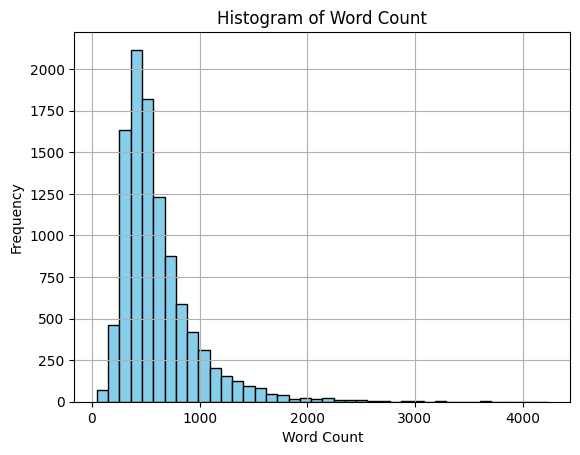

In [8]:
# Plot histogram for word count
plt.hist(df['Word Count'], bins=40, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Class Count Histogram

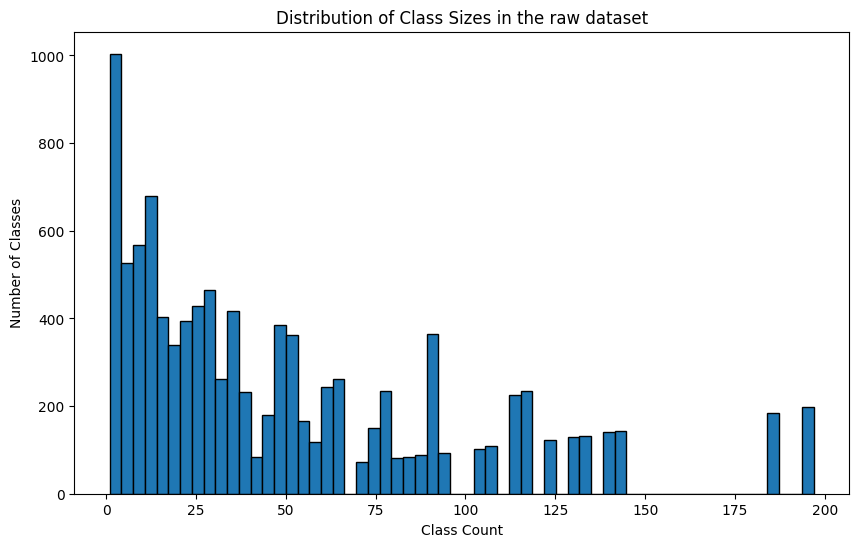

In [9]:
plt.figure(figsize=(10,6))
plt.hist(df['Class Count'], bins=60, edgecolor='black')
plt.title('Distribution of Class Sizes in the raw dataset')
plt.xlabel('Class Count')
plt.ylabel('Number of Classes')
plt.show()

# Extract Dataset

Get only class that has `Class Count` > 17

In [10]:
# extracted_df
e_df = df.loc[df['Class Count'] > 17].sort_values(by="Class Count", ascending=False)
e_df.count()

Content        7220
Label          7220
Word Count     7220
Class Count    7220
dtype: int64

In [11]:
number_of_classes = e_df['Label'].nunique()
number_of_classes

156

# Processing Dataset

## Clean text

In [14]:
vn_stopwords_url = 'https://raw.githubusercontent.com/duongnghia222/News_classification/main/vietnamese-stopwords.txt'
with open('vietnamese-stopwords.txt', 'w', encoding='utf-8-sig') as file:
    file.write(requests.get(vn_stopwords_url).text)

In [15]:
with open('/content/vietnamese-stopwords.txt', 'r', encoding='utf-8') as f:
    vietnamese_stopwords = f.read().splitlines()

vietnamese_stopwords[:10]

['\ufeffa lô',
 'a ha',
 'ai',
 'ai ai',
 'ai nấy',
 'ai đó',
 'alô',
 'amen',
 'anh',
 'anh ấy']

In [16]:
def clean_text(txt):
    txt = re.sub('\s+', ' ', txt)
    txt = txt.replace('.','')
    txt = re.sub('\n', ' ', txt)
    txt = [word_tokenize(wrd) for wrd in txt.split() if wrd not in vietnamese_stopwords]
    txt = [item[0] for item in txt]
    txt = ' '.join(txt)
    return txt

clean_text(" VinFast chính thức vận hành 35 showroom xe máy điện kết hợp trung tâm trải nghiệm Vin3S tại 24 tỉnh, thành phố trên cả nước")

'VinFast thức vận hành 35 showroom xe máy điện kết hợp trung tâm trải nghiệm Vin3S 24 tỉnh thành phố'

In [17]:
# e_df['Content'] = e_df['Content'].apply(clean_text)
e_df.head()

,Content,Label,Word Count,Class Count
3945,Hòa Phát tiêu thụ thép xây dựng tăng 82%. Tron...,HPG,324,197
1809,Công ty Container Hòa Phát bị phạt hành chính ...,HPG,1053,197
7422,Sản lượng bán thép tháng 10 của Hòa Phát giảm ...,HPG,346,197
943,'Lão tướng' sáng lập FPT gọi Hoà Phát là... kỳ...,HPG,1035,197
2267,Cổ đông Hòa Phát quan tâm gì trước ngày đại hộ...,HPG,1271,197


## Transform labels

In [18]:
labels_list = e_df['Label'].tolist()
print(labels_list[:10])

['HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG']


In [19]:
le = LabelEncoder()
labels = le.fit_transform(labels_list).tolist()
print(labels[-10:])

[142, 142, 101, 142, 31, 31, 73, 73, 31, 31]


Save file for later prediction

In [20]:
joblib.dump(le, 'label_encoder.joblib')

['label_encoder.joblib']

In [21]:
e_df['Encode Label'] = labels
e_df.head(10)

,Content,Label,Word Count,Class Count,Encode Label
3945,Hòa Phát tiêu thụ thép xây dựng tăng 82%. Tron...,HPG,324,197,55
1809,Công ty Container Hòa Phát bị phạt hành chính ...,HPG,1053,197,55
7422,Sản lượng bán thép tháng 10 của Hòa Phát giảm ...,HPG,346,197,55
943,'Lão tướng' sáng lập FPT gọi Hoà Phát là... kỳ...,HPG,1035,197,55
2267,Cổ đông Hòa Phát quan tâm gì trước ngày đại hộ...,HPG,1271,197,55
2111,Hòa Phát quý III: Chi phí tài chính hơn 2.300 ...,HPG,693,197,55
5448,"Nhà máy Dung Quất đi vào hoạt động, Hòa Phát t...",HPG,1331,197,55
3878,Hòa Phát muốn rót 85.000 tỷ đồng để mở rộng Kh...,HPG,425,197,55
5405,Hòa Phát sản xuất container: Những bài toán đã...,HPG,1784,197,55
2669,"Hòa Phát có thêm 18.000 cổ đông sau một năm, H...",HPG,720,197,55


## Split trainset valset

In [22]:
trainset, valset = train_test_split(e_df, test_size=0.2, stratify=e_df['Encode Label'])
print(len(trainset))
trainset = trainset.drop_duplicates(subset=['Label', 'Word Count'], keep='first')
print(len(trainset))
trainset['Class Count'] = trainset.groupby('Label')['Label'].transform('count')
valset['Class Count'] = valset.groupby('Label')['Label'].transform('count')
print("How many unique labels in the trainset", trainset['Encode Label'].nunique())
print("How many unique labels in the valset", valset['Encode Label'].nunique())

5776
5447
How many unique labels in the trainset 156
How many unique labels in the valset 156


# Visualize Extracted Data

In [23]:
trainset_unique_label = trainset.drop_duplicates(subset='Encode Label').sort_values(by="Class Count")
trainset_unique_label.head()

,Content,Label,Word Count,Class Count,Encode Label
323,Ocean Group thoát lỗ quý II nhờ giảm nợ sau ph...,OCH,847,13,90
8615,"Giá thép giảm mạnh, Thép Pomina (POM) lỗ sau t...",POM,336,13,101
7477,"Ông Nguyễn Mạnh Tuấn “A7” rời HĐQT, kế hoạch đ...",L14,640,13,73
6665,"HDBank thu được 8,016 tỷ đồng lãi trước thuế s...",HDB,297,14,49
646,Lãi ròng năm 2023 của Dat Xanh Services dự phó...,DXS,590,14,31


## Class Distribution Histogram

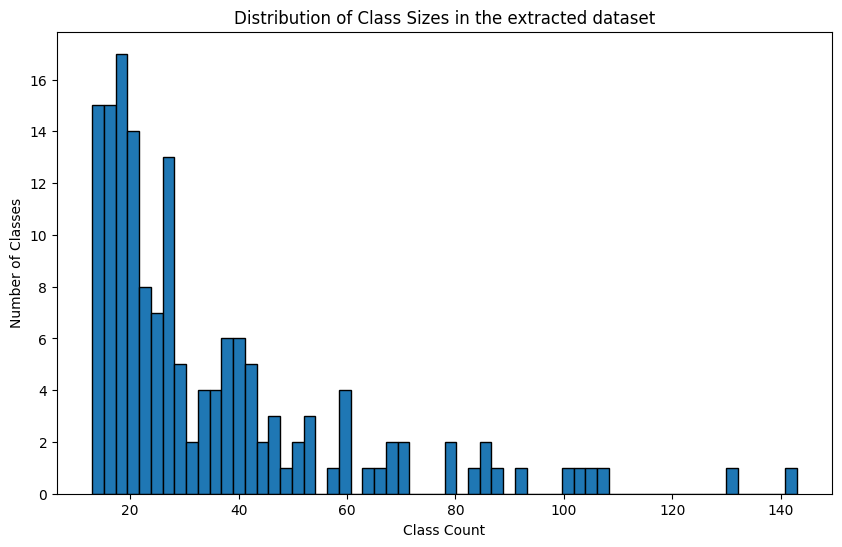

In [24]:
plt.figure(figsize=(10,6))
plt.hist(trainset_unique_label['Class Count'], bins=60, edgecolor='black')
plt.title('Distribution of Class Sizes in the extracted dataset')
plt.xlabel('Class Count')
plt.ylabel('Number of Classes')
plt.show()


## Class Distribution PieChart

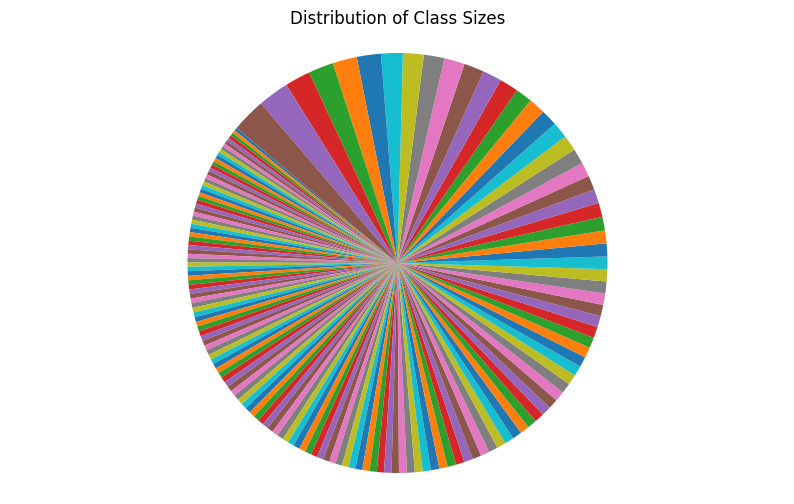

In [25]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
sizes = trainset_unique_label['Class Count'].values

plt.figure(figsize=(10,6))
plt.pie(sizes, startangle=140)
plt.title('Distribution of Class Sizes')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Trainset is unbalance

# Balance Dataset

In [26]:
def balance_data(df, target_count, max_length):
    balanced_df = pd.DataFrame(columns=df.columns)
    for label in df['Label'].unique():
        label_df = df[df['Label'] == label]
        count = len(label_df)

        if count >= target_count:
            label_df = label_df.sample(n=target_count, random_state=42)
        else:
            additional_samples_needed = target_count - count
            samples_per_row = (additional_samples_needed // count) + 1
            additional_samples = []

            for _, row in label_df.iterrows():
                content = row['Content']
                sentences = nltk.tokenize.sent_tokenize(content)

                window_start = 0

                for _ in range(samples_per_row):
                    picked_sentences = []
                    word_count = 0
                    i = window_start  # Set i to the start of the current window

                    while i < len(sentences):
                        sentence = sentences[i]
                        sentence_word_count = len(sentence.split())

                        if word_count + sentence_word_count > max_length:
                            break

                        picked_sentences.append(sentence)
                        word_count += sentence_word_count
                        i += 1

                    # No need to remove picked sentences from the list

                    if len(picked_sentences) > 0:
                        new_sample = pd.Series(data=copy.deepcopy(row.values), index=df.columns)
                        new_sample['Content'] = ' '.join(picked_sentences)
                        new_sample['Word Count'] = len(new_sample['Content'].split())
                        if new_sample['Word Count'] <= max_length:
                            additional_samples.append(new_sample)

                    # Slide the window by one sentence
                    if window_start + 1 < len(sentences):
                        window_start += 1
                    else:
                        break  # Break the loop if we've processed all sentences

            # This is a new block of code to limit the number of samples
            # We randomly select 'target_count' samples if there are more than 'target_count' samples
            if len(additional_samples) + count > target_count:
                additional_samples = random.sample(additional_samples, target_count - count)

            additional_samples = pd.DataFrame(additional_samples)
            label_df = pd.concat([label_df, additional_samples], ignore_index=True)

        balanced_df = pd.concat([balanced_df, label_df], ignore_index=True)

    return balanced_df


In [27]:
balanced_trainset = balance_data(trainset, target_count=50, max_length=150)

In [28]:
balanced_trainset['Class Count'] = balanced_trainset.groupby('Label')['Label'].transform('count')
print("How many unique labels in the trainset", balanced_trainset['Encode Label'].nunique())
# df['Word Count'] = balanced_trainset['Content'].apply(lambda x: len(str(x).split()))
balanced_trainset.head()

How many unique labels in the trainset 156


,Content,Label,Word Count,Class Count,Encode Label
0,Lợi nhuận Gemadept tăng 86% quý I nhờ nguồn th...,GMD,466,50,43
1,BSC: Viconship sẽ thành doanh nghiệp cảng lớn ...,GMD,671,50,43
2,Cảng Gemalink có thể đạt điểm hoà vốn trong nă...,GMD,1168,50,43
3,"Gemadept lãi ròng gần 670 tỷ 7 tháng, chốt ngà...",GMD,611,50,43
4,Gemadept (GMD) khai trương Giai đoạn 2 của Cụm...,GMD,473,50,43


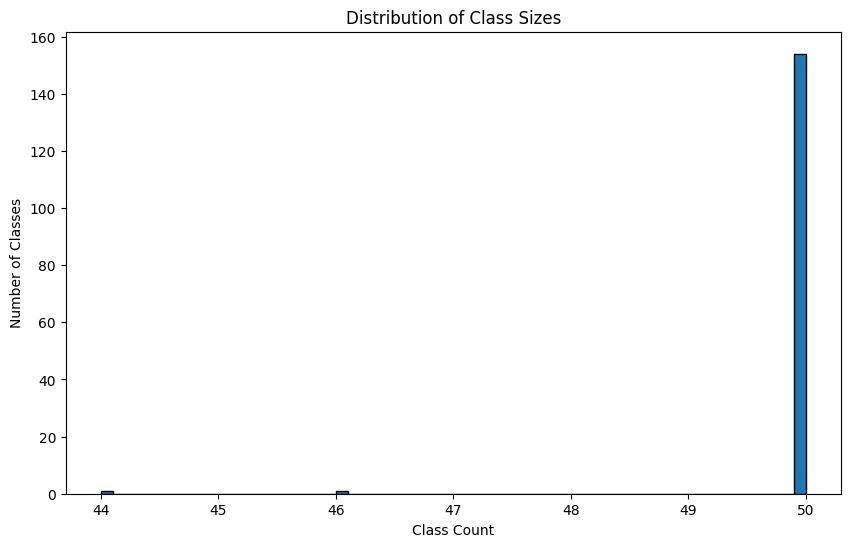

In [29]:
plt.figure(figsize=(10,6))
plt.hist(balanced_trainset.drop_duplicates(subset='Encode Label').sort_values(by="Class Count")['Class Count'], bins=60, edgecolor='black')
plt.title('Distribution of Class Sizes')
plt.xlabel('Class Count')
plt.ylabel('Number of Classes')
plt.show()

In [30]:
balanced_trainset[balanced_trainset['Encode Label'] == random.randint(0, number_of_classes)].sort_values(by="Word Count").head()

,Content,Label,Word Count,Class Count,Encode Label
2027,Nhà Đà Nẵng (NDN) biến động lãnh đạo.,NDN,8,50,84
2042,Gây thất thoát tài sản nhà nước khi cổ phần hó...,NDN,24,50,84
2017,Nhà Đà Nẵng báo lãi kỷ lục nhờ dự án Monarchy ...,NDN,58,50,84
2038,(ĐTCK) Công ty cổ phần Đầu tư phát triển Nhà Đ...,NDN,74,50,84
2032,Nhà Đà Nẵng (NDN) bổ nhiệm thêm lãnh đạo. (ĐTC...,NDN,74,50,84


# Load phoBERT tokenizer

In [31]:
checkpoint_model = 'vinai/phobert-base-v2'

In [32]:
# Load pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained(checkpoint_model, use_fast=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [33]:
text = "công tyNếu tính GJK"
print(tokenizer.encode(text))
text = "công ty Nếu tính gjk"
print(tokenizer.encode(text))

[0, 675, 6745, 313, 294, 1276, 2136, 2260, 2]
[0, 675, 6892, 313, 294, 1529, 57202, 2]


# Hyperparameters


In [34]:
MAX_LENGTH = 256  # Adjust as needed
BATCH_SIZE = 32
LR = 5e-5
N_CLASSES = number_of_classes  # Replace with your actual number of classes
EPOCHS = 100

# ArticleDataset Class

In [35]:
class ArticleDataset(Dataset):
    def __init__(self, data, labels, tokenizer, max_length=256):
        self.data = data
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        label = item.get('Encode Label')
        encoding = self.tokenizer.encode_plus(
            text=item.Content,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'content': item.Content,
            'input_ids':encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }



# Pytorch Lightning DataLoader

In [36]:
class Data_Module(pl.LightningDataModule):
    def __init__(self, trainset, valset, labels, batch_size: int = 32, max_token_length: int = 256, tokenizer=None):
      super().__init__()
      self.trainset = trainset
      self.val_path = valset
      self.labels = labels
      self.batch_size = batch_size
      self.max_token_length = max_token_length
      self.tokenizer = tokenizer

    def setup(self, stage = None):
      if stage in (None, "fit"):
        self.train_dataset = ArticleDataset(self.trainset, self.labels, self.tokenizer, self.max_token_length)
        self.val_dataset = ArticleDataset(self.val_path, self.labels, self.tokenizer, self.max_token_length)
      if stage == 'predict':
        self.val_dataset = ArticleDataset(self.val_path, self.labels, self.tokenizer, self.max_token_length)

    def train_dataloader(self):
      return DataLoader(self.train_dataset, batch_size = self.batch_size, num_workers=2, shuffle=True)

    def val_dataloader(self):
      return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=2, shuffle=False)

    def predict_dataloader(self):
      return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=2, shuffle=False)

# Create PyTorch-lightning DataLoader

In [37]:
# Create PyTorch lightning DataLoader
data_loader = Data_Module(balanced_trainset, valset, labels, BATCH_SIZE, MAX_LENGTH, tokenizer)
data_loader.setup()
print("number of batches in an epoch: ", len(data_loader.train_dataloader()))

number of batches in an epoch:  244


# Model architecture

In [38]:
class ArticleClassifier(pl.LightningModule):
    def __init__(self, config: dict):
        super().__init__()
        self.config = config
        self.bert = AutoModelForSequenceClassification.from_pretrained(config['model_name'], num_labels=config['n_labels'])
        self.loss = nn.CrossEntropyLoss()


    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids, attention_mask).logits
        return x

# Model configuration

In [39]:
config = {
    'model_name': checkpoint_model,
    'n_labels': number_of_classes,
    'batch_size': BATCH_SIZE,
    'lr': LR,
    'warmup': 0.15,
    'train_size': len(data_loader.train_dataloader()),
    'weight_decay': 0.01,
    'n_epochs': EPOCHS,
    'early_stopping_limit': 3
}

# Create model

In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [41]:
# Initialize our classifier
model = ArticleClassifier(config)
model = model.to(device)

Some weights of the model checkpoint at vinai/phobert-base-v2 were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bi

# Model Summary

In [42]:
summary(model)

Layer (type:depth-idx)                                            Param #
ArticleClassifier                                                 --
├─RobertaForSequenceClassification: 1-1                           --
│    └─RobertaModel: 2-1                                          --
│    │    └─RobertaEmbeddings: 3-1                                49,353,216
│    │    └─RobertaEncoder: 3-2                                   85,054,464
│    └─RobertaClassificationHead: 2-2                             --
│    │    └─Linear: 3-3                                           590,592
│    │    └─Dropout: 3-4                                          --
│    │    └─Linear: 3-5                                           119,964
├─CrossEntropyLoss: 1-2                                           --
Total params: 135,118,236
Trainable params: 135,118,236
Non-trainable params: 0


# Train Model

In [43]:
def train_model(model, data_loader, config, model_path=None):
    if model_path is not None:
          # Load the pre-trained model
          model = torch.load(model_path)

    model = model.to(device)
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

    total_steps = config['train_size']/config['batch_size']
    warmup_steps = math.floor(total_steps * config['warmup'])
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)

    best_valid_loss = float('inf')
    early_stopping_counter = 0
    early_stopping_limit = config['early_stopping_limit']  # Number of epochs with no improvement after which training will be stopped
    save_model_path = 'NPL_news_classification.pt'  # path where best model will be saved

    progress_bar = tqdm(range(config['n_epochs']), desc="Training", total=config['n_epochs'])

    for epoch in progress_bar:
        start_time = time.time()  # start time of the epoch

        model.train()
        total_loss = 0

        train_predictions , train_true_labels = [], []

        for batch in data_loader.train_dataloader():
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids, attention_mask)

            loss = model.loss(logits, labels)
            total_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            labels = labels.to('cpu').numpy()

            # Store train predictions and true labels for accuracy calculation
            train_predictions.append(logits)
            train_true_labels.append(labels)

            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(data_loader.train_dataloader())

        # Calculate training accuracy
        train_predictions = np.concatenate(train_predictions, axis=0)
        train_true_labels = np.concatenate(train_true_labels, axis=0)
        train_accuracy = accuracy_score(train_true_labels, np.argmax(train_predictions, axis=1))

        # Start the validation
        model.eval()

        predictions , true_labels = [], []
        total_eval_loss = 0

        for batch in data_loader.val_dataloader():
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            with torch.no_grad():
                logits = model(input_ids, attention_mask)

            loss = model.loss(logits, labels)
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            labels = labels.to('cpu').numpy()

            # Store predictions and true labels
            predictions.append(logits)
            true_labels.append(labels)

        # Calculate the average loss over all of the batches
        avg_val_loss = total_eval_loss / len(data_loader.val_dataloader())

        # Calculate validation accuracy
        predictions = np.concatenate(predictions, axis=0)
        true_labels = np.concatenate(true_labels, axis=0)
        val_accuracy = accuracy_score(true_labels, np.argmax(predictions, axis=1))

        end_time = time.time()  # end time of the epoch
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)  # calculate elapsed time for this epoch

        # Print additional information after each epoch
        print(f'\nEpoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {avg_train_loss:.3f} | Train Acc: {train_accuracy*100:.2f}% | Valid Loss: {avg_val_loss:.3f} | Valid Acc: {val_accuracy*100:.2f}%')

        # Update progress bar
        progress_bar.set_postfix({'train_loss': avg_train_loss, 'valid_loss': avg_val_loss, 'valid_acc': val_accuracy, 'train_acc': train_accuracy})

        # save model if validation loss has decreased
        if avg_val_loss < best_valid_loss:
            best_valid_loss = avg_val_loss
            torch.save(model, save_model_path)
            early_stopping_counter = 0  # reset counter
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_limit:
                print(f'EarlyStopping counter: {early_stopping_counter} out of {early_stopping_limit}')
                if early_stopping_counter >= early_stopping_limit:
                    print('Early stopping, stopping training')
                    break  # break out from the training loop


In [44]:
train_model(model, data_loader, config)

Training:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 01 | Time: 5.0m 56.70482611656189s
	Train Loss: 4.606 | Train Acc: 53.29% | Valid Loss: 3.776 | Valid Acc: 92.94%

Epoch: 02 | Time: 6.0m 1.5131139755249023s
	Train Loss: 3.354 | Train Acc: 94.29% | Valid Loss: 2.592 | Valid Acc: 94.53%

Epoch: 03 | Time: 6.0m 0.6432218551635742s
	Train Loss: 2.269 | Train Acc: 96.42% | Valid Loss: 1.619 | Valid Acc: 94.60%

Epoch: 04 | Time: 6.0m 0.09044671058654785s
	Train Loss: 1.365 | Train Acc: 97.45% | Valid Loss: 0.948 | Valid Acc: 94.67%

Epoch: 05 | Time: 6.0m 0.46994447708129883s
	Train Loss: 0.762 | Train Acc: 98.29% | Valid Loss: 0.609 | Valid Acc: 94.67%

Epoch: 06 | Time: 6.0m 0.6222186088562012s
	Train Loss: 0.445 | Train Acc: 98.74% | Valid Loss: 0.439 | Valid Acc: 95.36%

Epoch: 07 | Time: 6.0m 0.027521848678588867s
	Train Loss: 0.279 | Train Acc: 99.01% | Valid Loss: 0.363 | Valid Acc: 94.74%

Epoch: 08 | Time: 5.0m 59.95961332321167s
	Train Loss: 0.178 | Train Acc: 99.32% | Valid Loss: 0.331 | Valid Acc: 95.01%

Epoch: 09 | T

# Predict

In [45]:
def test_model(model, data_loader, model_path=None):
    if model_path is not None:
        # Load the pre-trained model
        model = torch.load(model_path)

    model.eval()

    all_predictions, all_true_labels = [], []
    cnt = 0
    for batch in data_loader.val_dataloader():
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.no_grad():
            logits = model(input_ids, attention_mask)

        logits = logits.detach().cpu().numpy()
        labels = labels.to('cpu').numpy()

        # Get the predicted labels
        predicted_labels = np.argmax(logits, axis=1)

        # Store predictions and true labels
        all_predictions.append(predicted_labels)
        all_true_labels.append(labels)
        if cnt < 1:
          for i in range(BATCH_SIZE):
            print(f"Content: {batch['content'][i]}")
            print(f"Predicted Label: {le.inverse_transform([predicted_labels[i]])}")
            print(f"True Label: {le.inverse_transform([labels[i]])}")
            print("========================================")

        cnt += 1

    # Flatten the lists
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_true_labels = np.concatenate(all_true_labels, axis=0)

    # Calculate accuracy
    test_accuracy = accuracy_score(all_true_labels, all_predictions)
    print(" ===============================================")
    print()
    print(f'Test Accuracy: {test_accuracy}')
    print()
    print(" ===============================================")

    return all_predictions, all_true_labels, test_accuracy


In [46]:
# Test the model
predicted_labels, true_labels, test_accuracy = test_model(model, data_loader, "/content/NPL_news_classification.pt")

Content: Vietjet làm ăn ra sao trong quí III khi đại dịch tái bùng phát?. Dịch COVID-19 tái bùng phát tại Đà Nẵng vào cuối tháng 7 đã làm ảnh hưởng tiêu cực đến kết quả kinh doanh quí III của Vietjet. Công ty đang nỗ lực cắt giảm chi phí và tìm nguồn thu mới để khắc phục khó khăn. Tàu bay Vietjet Air tại Nội Bài. (Ảnh: Song Ngọc) Công ty cổ phần Hàng không Vietjet (Mã: VJC) mới công bố báo cáo tài chính quí III/2020 cho thấy doanh thu thuần sụt giảm gần 80% so với cùng kì năm ngoái còn 2.809 tỉ đồng. Sau khi trừ giá vốn hàng bán, Vietjet lỗ gộp 612 tỉ đồng, trong khi quí III/2019 có lãi gộp hơn 2.000 tỉ đồng. Trong quí II năm nay, Vietjet cũng lỗ gộp nhưng nhờ có doanh thu tài chính cao đột biến gần 2.000 tỉ đồng nên công ty lãi thuần nghìn tỉ.  Tuy nhiên trong quí III vừa qua, công ty không ghi nhận doanh thu tài chính bất thường nên lợi nhuận sau thuế âm 971 tỉ đồng. Quí III năm ngoái, Vietjet có lãi ròng xấp xỉ 1.700 tỉ đồng. Nói về nguyên nhân chuyển từ lãi cùng kì năm trước sang l

In [47]:
report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       1.00      1.00      1.00         4
           2       0.70      0.78      0.74         9
           3       0.86      0.86      0.86         7
           4       1.00      1.00      1.00         7
           5       0.80      1.00      0.89         4
           6       0.86      1.00      0.92         6
           7       1.00      1.00      1.00         9
           8       0.95      1.00      0.97        18
           9       0.91      1.00      0.95        10
          10       1.00      0.83      0.91         6
          11       0.88      1.00      0.93         7
          12       0.93      1.00      0.96        13
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         6
          16       1.00      0.88      0.94        17
          17       1.00    

# Naive Bayes

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [49]:
test_content = e_df.iloc[1].get("Content")
print(test_content)
print("------------------------------------------------------------")
sentences = nltk.tokenize.sent_tokenize(test_content)
for s in sentences:
  print(s)

Công ty Container Hòa Phát bị phạt hành chính 130 triệu đồng. Dự án nhà máy Sản xuất Container Hòa Phát tại tỉnh Bà Rịa – Vũng Tàu tổ chức thi công xây dựng khi chưa có giấy phép xây dựng. Hòa Phát đặt mục tiêu bán ra sản phẩm container đầu tiên trong quý IV năm nay. Ủy ban nhân dân tỉnh Bà Rịa – Vũng Tàu vừa cho biết Chủ tịch UBND tỉnh ngày 21/4 đã ban hành quyết định về việc xử phạt vi phạm hành chính đối với Công ty cổ phần Sản xuất Container Hòa Phát. Nguyên nhân là công ty đã tổ chức thi công xây dựng Nhà máy sản xuất container chở hàng khô theo tiêu chuẩn quốc tế tại Khu công nghiệp Phú Mỹ II mở rộng, thị xã Phú Mỹ mà không có giấy phép xây dựng. Container Hòa Phát bị phạt tiền 130 triệu đồng và phải dừng thi công công trình. Ngoài ra, công ty phải hoàn thành hồ sơ đề nghị cơ quan có thẩm quyền cấp giấy phép xây dựng. Thời hạn thực hiện biện pháp khắc phục hậu quả là 90 ngày, kể từ ngày nhận được quyết định xử phạt. Cũng trong ngày 21/4, Chủ tịch UBND tỉnh Bà Rịa – Vũng Tàu ra qu

In [50]:
train_data, test_data, train_labels, test_labels = train_test_split(e_df['Content'], e_df['Encode Label'], random_state=42)

In [51]:
model_nb = make_pipeline(CountVectorizer(), MultinomialNB())

In [52]:
# Train the model
model_nb.fit(train_data, train_labels)


Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [53]:
# Predict the labels of the test set
predictions = model_nb.predict(test_data)

# Print out the accuracy
print(f"Accuracy: {accuracy_score(test_labels, predictions)}")

Accuracy: 0.6271468144044321
